In [13]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os
from scipy import fftpack
from scipy.signal import medfilt

In [8]:
root = 'torres_paine_pan.mp4'
cam = cv.VideoCapture(root)


In [9]:
currentframe = 30
vid = cv.VideoCapture(root)

spthreshold=0.999

properties = {'width': int(vid.get(cv.CAP_PROP_FRAME_WIDTH)),
                           'height': int(vid.get(cv.CAP_PROP_FRAME_HEIGHT)),
                           'fps': vid.get(cv.CAP_PROP_FPS)}

y = np.linspace(0, properties['height'], num=properties['height'])
x = np.linspace(0, properties['width'], properties['width'])
X, Y = np.meshgrid(x, y)
noise_angle = 2.0*np.pi*(20*Y + 2*X)
ret,frame = cam.read()
current_original_frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
noisy_frame = current_original_frame.copy().astype(np.float32)/255.        
periodic_noise = 0.5 + 0.5*np.cos(noise_angle  - currentframe *0.1)
periodic_noise = periodic_noise.reshape(noisy_frame.shape)
noisy_frame += periodic_noise
noisy_frame /= np.amax(np.abs(noisy_frame))

spprob = np.random.rand(properties['height'], properties['width'])
smask = spprob > spthreshold
pmask = spprob < 1. - spthreshold
noisy_frame[smask] = 1.
noisy_frame[pmask] = 0.
noisy_frame=255*noisy_frame

name = 'frame'+str(currentframe)+'.jpg'
cv.imwrite(name,noisy_frame)
name = 'frame'+str(currentframe+1)+'.jpg'
cv.imwrite(name,frame);

<IPython.core.display.Javascript object>


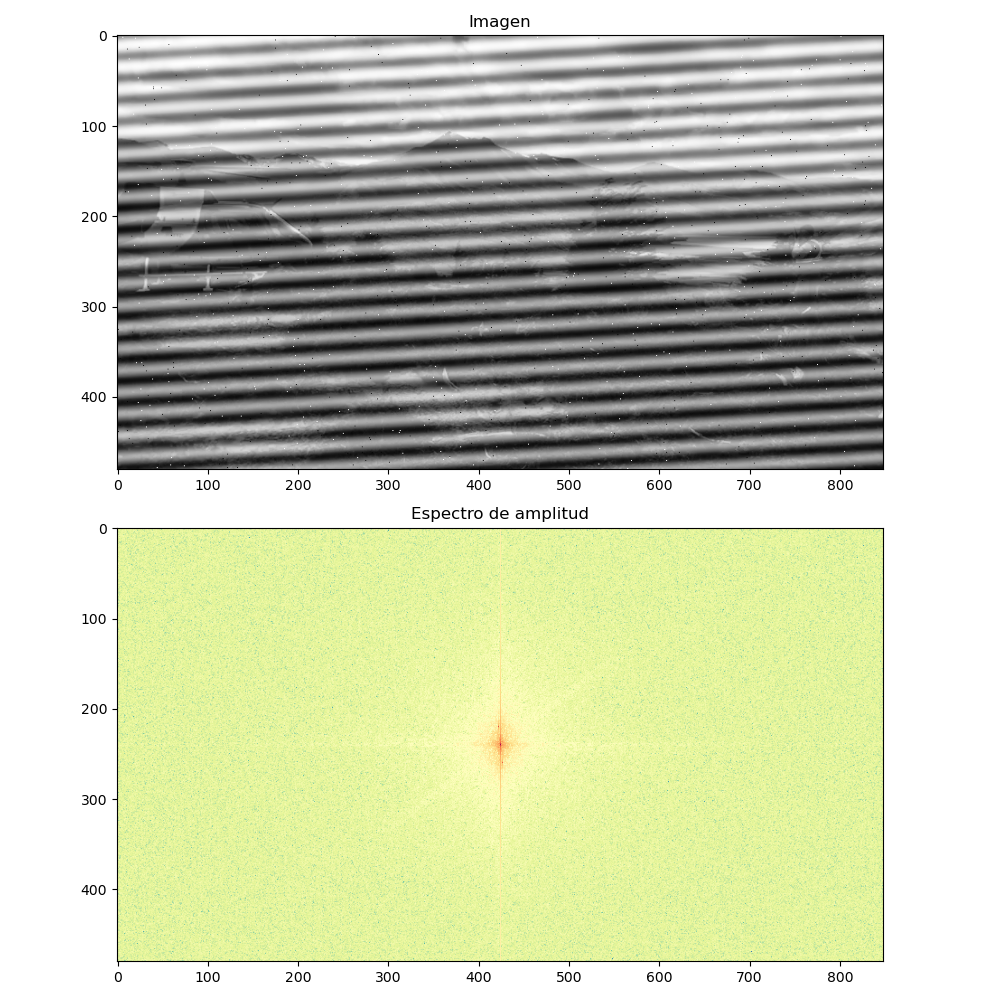

In [10]:

fig, ax = plt.subplots(2, 1, figsize=(10, 10), tight_layout=True)
ax[0].imshow(noisy_frame, cmap=plt.cm.Greys_r) 
ax[0].set_title("Imagen")
S = fftpack.fft2(noisy_frame)
ax[1].imshow(fftpack.fftshift(np.log(1+np.abs(S))), cmap=plt.cm.Spectral_r)
ax[1].set_title("Espectro de amplitud");

In [11]:

def create_mask(dims, frequency, size=3):
    freq_int = int(frequency*dims[0])
    mask = np.ones(shape=(dims[0], dims[1]))
    mask[dims[0]//2-size-freq_int+1:dims[0]//2+size-freq_int, dims[1]//2-size:dims[1]//2+size] = 0 
    mask[dims[0]//2-size+freq_int+1:dims[0]//2+size+freq_int, dims[1]//2-size:dims[1]//2+size] = 0
    return mask


<IPython.core.display.Javascript object>


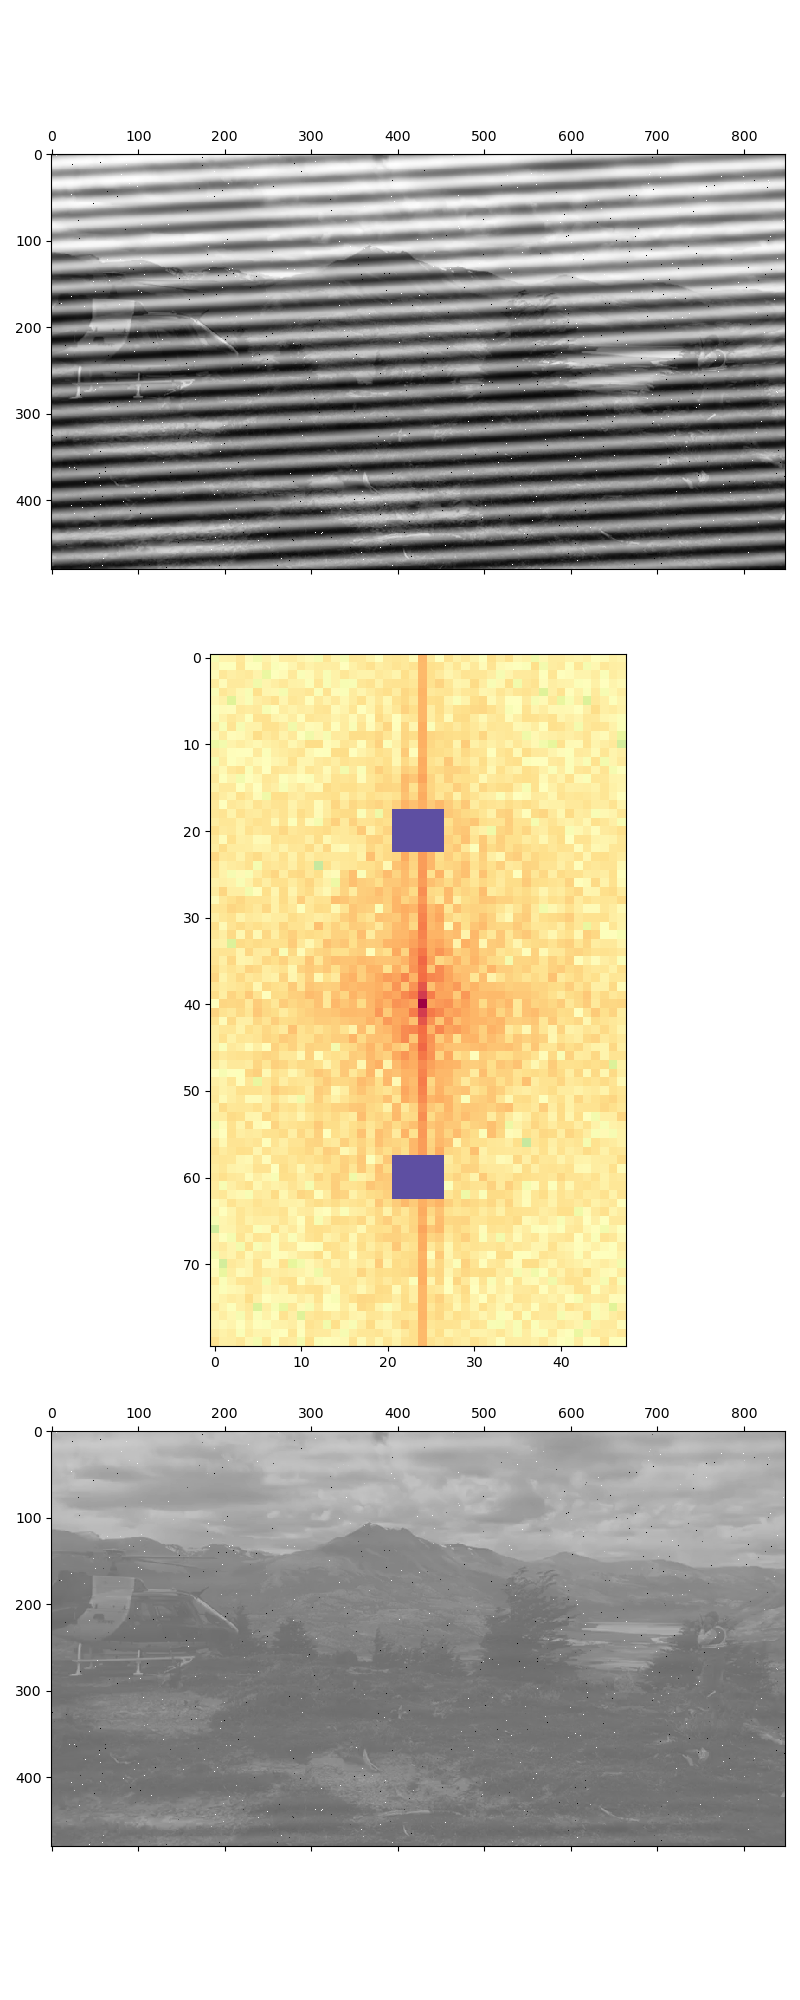

In [12]:

S_img= fftpack.fftshift(fftpack.fft2(noisy_frame))
espectro_filtrado = S_img*create_mask(S_img.shape, 0.042)
img_reconstructed = np.real(fftpack.ifft2(fftpack.ifftshift(espectro_filtrado)))

fig, ax = plt.subplots(3, 1, figsize=(8, 20), tight_layout=True)
ax[0].matshow(noisy_frame, cmap=plt.cm.Greys_r);
ax[1].imshow(np.log(1+np.abs(espectro_filtrado))[200:-200, 400:-400], cmap=plt.cm.Spectral_r)
ax[2].matshow(img_reconstructed, cmap=plt.cm.Greys_r);

name = 'frame'+str(currentframe+2)+'.jpg'
cv.imwrite(name,img_reconstructed);

<IPython.core.display.Javascript object>


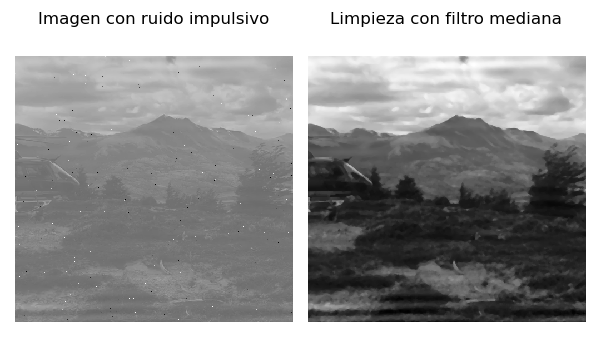

In [15]:


img_filtered = medfilt(img_reconstructed, 5)

fig, ax = plt.subplots(1, 2, figsize=(6, 3.5), tight_layout=True, sharex=True, sharey=True)
ax[0].matshow(img_reconstructed[:, 100:600], cmap=plt.cm.Greys_r)     
ax[0].set_title('Imagen con ruido impulsivo')
ax[0].axis('off')
ax[1].matshow(img_filtered[:, 100:600], cmap=plt.cm.Greys_r)
ax[1].set_title('Limpieza con filtro mediana')
ax[1].axis('off');